<a href="https://colab.research.google.com/github/Bharathsmart/Whats-Cooking/blob/master/Planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Planet***

In [0]:
# Multi-label prediction with Planet Amazon dataset

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

***Getting the data***

In [0]:
# First, install the Kaggle API by uncommenting the following line and executing it.

# ! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


Then you need to upload your credentials from Kaggle on your instance. 

Login to kaggle and click on your profile picture on the top left corner, then 'My account'. 

Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

In [4]:
from google.colab import files 
upload = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [6]:

# For Windows, uncomment these two commands
! mkdir %userprofile%\.kaggle
! move kaggle.json %userprofile%\.kaggle

/bin/bash: move: command not found


In [7]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [8]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 97% 582M/600M [00:06<00:00, 53.0MB/s]
100% 600M/600M [00:06<00:00, 95.2MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 55.1MB/s]


In [0]:
! chmod 600 /root/.kaggle/kaggle.json

In [10]:
! sudo apt install p7zip-full


Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
# And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

***Multiclassification***

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels.

If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.



In [12]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

# We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\'.

np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

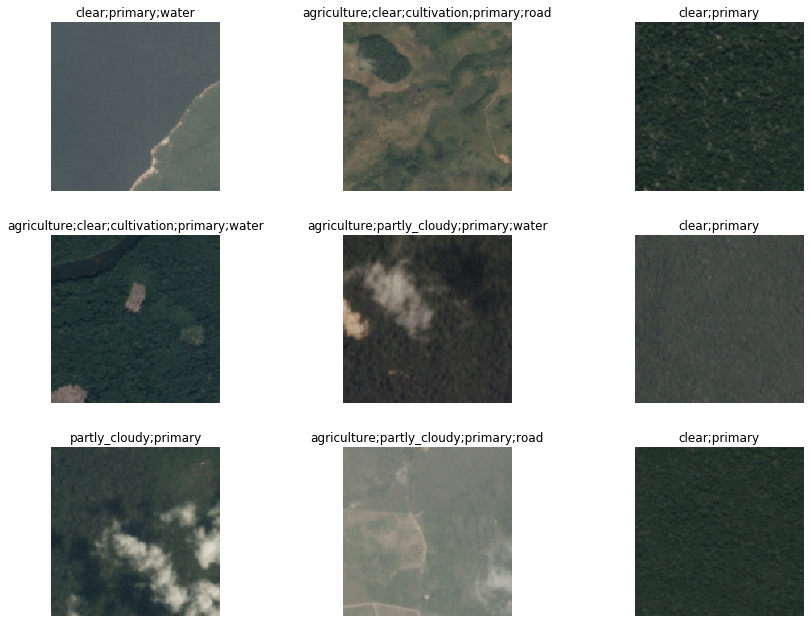

In [14]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))


# show_batch still works, and show us the different labels separated by ;.

data.show_batch(rows=3, figsize=(12,9))

In [17]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 100841733.48it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


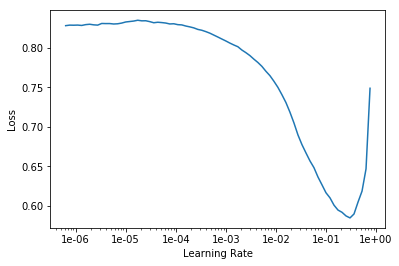

In [18]:
# We use the LR Finder to pick a good learning rate.

learn.lr_find()


# LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

learn.recorder.plot()

In [0]:
# Then we can fit the head of our network.

lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127150,0.109213,0.947360,0.905103,03:59
1,0.109538,0.097786,0.952040,0.916782,03:55
2,0.099049,0.093116,0.956052,0.917883,03:54
3,0.095225,0.088903,0.958282,0.923508,03:54
4,0.091144,0.086877,0.957236,0.925799,03:56


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


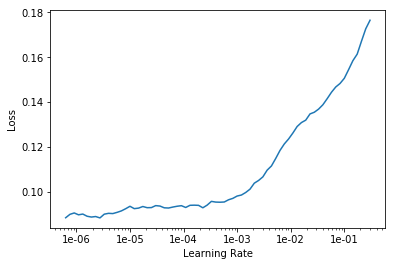

In [0]:
learn.save('stage-1-rn50')


# ...And fine-tune the whole model:

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 0.01
learn.fit_one_cycle(4, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095253,0.090658,0.954358,0.921410,04:29
1,0.100404,0.088942,0.952476,0.924109,04:29
2,0.091073,0.085898,0.957853,0.924988,04:29
3,0.083466,0.083154,0.958428,0.928314,04:28
4,0.081519,0.082574,0.959343,0.928676,04:28


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


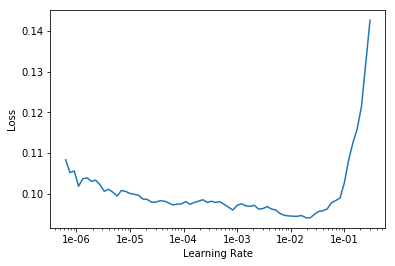

In [0]:
learn.save('stage-2-rn50')
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.132687,0.112390,0.942361,0.899997,04:09
1,0.112389,0.100226,0.949693,0.909071,04:06
2,0.104222,0.094081,0.952760,0.916169,04:08
3,0.096191,0.090052,0.954620,0.920943,04:08
4,0.093607,0.089218,0.953770,0.922197,04:06


In [20]:
learn.save('stage-1-256-rn50')
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096375,0.092432,0.952759,0.916591,04:33
1,0.097197,0.089834,0.954787,0.920064,04:35
2,0.090971,0.086794,0.956000,0.924424,04:31
3,0.084446,0.083177,0.958791,0.929400,04:34
4,0.078540,0.082661,0.958275,0.928800,04:31


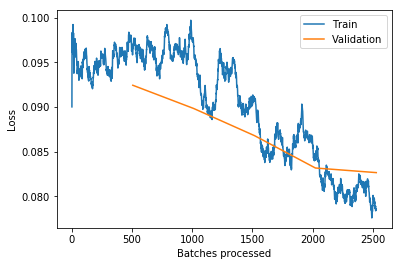

In [21]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

learn.export()

***Finall***

In [23]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}


 98% 593M/603M [00:07<00:00, 74.2MB/s]
100% 603M/603M [00:07<00:00, 89.1MB/s]
 99% 301M/304M [00:04<00:00, 108MB/s]
100% 304M/304M [00:04<00:00, 77.5MB/s]


In [24]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)



In [26]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]


labelled_preds[:5]

['agriculture clear habitation primary road water',
 'agriculture clear cultivation primary water',
 'clear primary',
 'clear primary water',
 'agriculture clear cultivation primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

df.to_csv(path/'submission.csv', index=False)

In [28]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100% 2.19M/2.19M [00:03<00:00, 618kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space